# **1. LIBRARIES**

In [ ]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, TFBertForSequenceClassification, BertConfig
from tensorflow.keras.optimizers import Adam
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
import pandas as pd
from google.colab import drive
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
import re
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.metrics import classification_report
import seaborn as sns
import torch
from tqdm import tqdm
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# **2. DATA PREPROCESSING**

In [ ]:
# DRIVE
# drive.mount('/content/drive')
# df = pd.read_csv('/content/drive/MyDrive/dataset_UAS.csv')


df = pd.read_csv('dataset_UAS.csv')
df = df.rename(columns={'sentimen (positif 1, netral 2, negatif3)': 'sentimen'})
df

,full_text,sentimen,anies,ganjar,prabowo
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,Amin 👍 #AMINUntukKemakmuranDesa #AniesMuhaimi...,positif,1.0,0.0,0.0
3,#AMINUntukKemakmuranDesa #AniesMuhaimin2024 @...,positif,1.0,0.0,0.0
4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
11167,Ribuan perangkat desa dan kepala desa ditenga...,NaN,NaN,NaN,NaN
11168,"Ganjar presiden, Mahfud MD wakil, pilihan cerd...",NaN,NaN,NaN,NaN
11169,"Ganjar presiden, Mahfud MD wakil, impian Jabar...",NaN,NaN,NaN,NaN
11170,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.dropna(subset=['full_text'], inplace=True)
df.reset_index(drop=True, inplace=True)
df

,full_text,sentimen,anies,ganjar,prabowo
0,Amin 👍 #AMINUntukKemakmuranDesa #AniesMuhaimi...,positif,1.0,0.0,0.0
1,#AMINUntukKemakmuranDesa #AniesMuhaimin2024 @...,positif,1.0,0.0,0.0
2,@voiceofpkb @cakimiNOW @aniesbaswedan Kemakmur...,positif,1.0,0.0,0.0
3,@voiceofpkb @cakimiNOW @aniesbaswedan AMIN unt...,positif,1.0,0.0,0.0
4,@DPP_PKB @cakimiNOW Amin sangat mendukung kena...,positif,1.0,0.0,0.0
...,...,...,...,...,...
8142,@abu_waras Jargon kampanye tim kampanye @prabo...,NaN,NaN,NaN,NaN
8143,Ribuan perangkat desa dan kepala desa ditenga...,NaN,NaN,NaN,NaN
8144,"Ganjar presiden, Mahfud MD wakil, pilihan cerd...",NaN,NaN,NaN,NaN
8145,"Ganjar presiden, Mahfud MD wakil, impian Jabar...",NaN,NaN,NaN,NaN


In [ ]:
df['sentimen'].unique()

array(['positif', 'netral', 'negatif', 'netral ', 'positif ', 'negatif ',
       nan, '1', '3', '2', 'posiitf', 'positig', ' netral', ' negatif',
       'Netral', 'Positif', 'Negatif'], dtype=object)

In [ ]:
# Membuat dictionary untuk mapping nilai sentimen ke angka
# 0 = positif, 1 = netral, 2 = negatif
mapping = {'positif': 0, 'netral': 1, 'negatif': 2,
           'positif ': 0, 'netral ': 1, 'negatif ':2,
           'posiitf': 0, 'positig': 0, ' netral': 1,
           'Netral': 1 , 'Positif': 0, 'Negatif': 2,
           '1':0,'2':1,'3':2}

df['sentimen'] = df['sentimen'].astype(str)

# Mengubah nilai pada kolom "sentimen" menggunakan map()
df['sentimen'] = df['sentimen'].map(mapping)
df

,full_text,sentimen,anies,ganjar,prabowo
0,Amin 👍 #AMINUntukKemakmuranDesa #AniesMuhaimi...,0.0,1.0,0.0,0.0
1,#AMINUntukKemakmuranDesa #AniesMuhaimin2024 @...,0.0,1.0,0.0,0.0
2,@voiceofpkb @cakimiNOW @aniesbaswedan Kemakmur...,0.0,1.0,0.0,0.0
3,@voiceofpkb @cakimiNOW @aniesbaswedan AMIN unt...,0.0,1.0,0.0,0.0
4,@DPP_PKB @cakimiNOW Amin sangat mendukung kena...,0.0,1.0,0.0,0.0
...,...,...,...,...,...
8142,@abu_waras Jargon kampanye tim kampanye @prabo...,NaN,NaN,NaN,NaN
8143,Ribuan perangkat desa dan kepala desa ditenga...,NaN,NaN,NaN,NaN
8144,"Ganjar presiden, Mahfud MD wakil, pilihan cerd...",NaN,NaN,NaN,NaN
8145,"Ganjar presiden, Mahfud MD wakil, impian Jabar...",NaN,NaN,NaN,NaN


In [ ]:
df['sentimen'].unique()

array([ 0.,  1.,  2., nan])

In [ ]:
data_train = df[
    df['full_text'].notna() &
    df['sentimen'].notna() &
    df['anies'].notna() &
    df['ganjar'].notna() &
    df['prabowo'].notna()
]
data_train.reset_index(drop=True, inplace=True)
data_train

,full_text,sentimen,anies,ganjar,prabowo
0,Amin 👍 #AMINUntukKemakmuranDesa #AniesMuhaimi...,0.0,1.0,0.0,0.0
1,#AMINUntukKemakmuranDesa #AniesMuhaimin2024 @...,0.0,1.0,0.0,0.0
2,@voiceofpkb @cakimiNOW @aniesbaswedan Kemakmur...,0.0,1.0,0.0,0.0
3,@voiceofpkb @cakimiNOW @aniesbaswedan AMIN unt...,0.0,1.0,0.0,0.0
4,@DPP_PKB @cakimiNOW Amin sangat mendukung kena...,0.0,1.0,0.0,0.0
...,...,...,...,...,...
6013,Keilmuan dan keahlian Mahfud MD di bidang huku...,0.0,0.0,1.0,0.0
6014,"Bersama Mahfud MD, pemuda Madura merasa memili...",0.0,0.0,1.0,0.0
6015,@ekowboy2 @ganjarpranowo @mohmahfudmd CALON ...,0.0,0.0,1.0,0.0
6016,Mahfud MD sebagai Calon Wakil Presiden memberi...,0.0,0.0,1.0,0.0


In [ ]:
data_test = df[
    df['full_text'].notna() &
    df['sentimen'].isna() &
    df['anies'].isna() &
    df['ganjar'].isna() &
    df['prabowo'].isna()
]
data_test = data_test["full_text"]
data_test.reset_index(drop=True, inplace=True)
data_test

0       Komunitas jasa sablon kaos di Kelurahan Genuk,...
1       @zy_zy_its_me Ga ada yang salah dalam pencalon...
2       @ganjarpranowo Hidup rakyat papua semoga denga...
3       @99propaganda @bengkeldodo @Ndons_Back @BANGSA...
4       @TeddGus @ganjarpranowo Teddy tau dan sangat s...
                              ...                        
1557    @abu_waras Jargon kampanye tim kampanye @prabo...
1558    Ribuan perangkat desa dan kepala desa  ditenga...
1559    Ganjar presiden, Mahfud MD wakil, pilihan cerd...
1560    Ganjar presiden, Mahfud MD wakil, impian Jabar...
1561    Ganjar presiden, suara hati rakyat! Mahfud MD,...
Name: full_text, Length: 1562, dtype: object

In [ ]:
def prepro(text):
    text = text.lower() # ubah jadi lower case
    text = re.sub(r"http\S+|www.\S+", ' ', text) # Menghapus url
    text = re.sub(r'@(\w+)', r'\1', text) #hapus @
    text = re.sub(r'#(\w+)', r'\1', text) #hapus #
    text = re.sub(r'_', ' ', text) # ubah underscore menjadi spasi
    text = re.sub(r'[^\w\s?!.,]', ' ', text) # hapus tanda baca selain "?", "!", "," , dan "."
    text = re.sub(r' +', ' ', text).strip() # Beresin spasi dobel
    return text

data_train["clean_text"] = data_train["full_text"].map(prepro)
data_train

<ipython-input-7-6ec192d43592>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train["clean_text"] = data_train["full_text"].map(prepro)


,full_text,sentimen,anies,ganjar,prabowo,clean_text
0,Amin 👍 #AMINUntukKemakmuranDesa #AniesMuhaimi...,0.0,1.0,0.0,0.0,amin aminuntukkemakmurandesa aniesmuhaimin2024...
1,#AMINUntukKemakmuranDesa #AniesMuhaimin2024 @...,0.0,1.0,0.0,0.0,aminuntukkemakmurandesa aniesmuhaimin2024 caki...
2,@voiceofpkb @cakimiNOW @aniesbaswedan Kemakmur...,0.0,1.0,0.0,0.0,voiceofpkb cakiminow aniesbaswedan kemakmuran ...
3,@voiceofpkb @cakimiNOW @aniesbaswedan AMIN unt...,0.0,1.0,0.0,0.0,voiceofpkb cakiminow aniesbaswedan amin untuk ...
4,@DPP_PKB @cakimiNOW Amin sangat mendukung kena...,0.0,1.0,0.0,0.0,dpp pkb cakiminow amin sangat mendukung kenaik...
...,...,...,...,...,...,...
6013,Keilmuan dan keahlian Mahfud MD di bidang huku...,0.0,0.0,1.0,0.0,keilmuan dan keahlian mahfud md di bidang huku...
6014,"Bersama Mahfud MD, pemuda Madura merasa memili...",0.0,0.0,1.0,0.0,"bersama mahfud md, pemuda madura merasa memili..."
6015,@ekowboy2 @ganjarpranowo @mohmahfudmd CALON ...,0.0,0.0,1.0,0.0,ekowboy2 ganjarpranowo mohmahfudmd calon kuat ...
6016,Mahfud MD sebagai Calon Wakil Presiden memberi...,0.0,0.0,1.0,0.0,mahfud md sebagai calon wakil presiden memberi...


In [ ]:
# kamus_df = pd.read_csv('/content/drive/MyDrive/singkatan+alay.csv')
kamus_df = pd.read_csv('kamus_alay.csv')
kamus = dict(zip(kamus_df['slang'], kamus_df['formal']))

def ganti_kata_alay(teks):
    kata_kata = teks.split()
    teks_hasil = " ".join([kamus.get(kata, kata) for kata in kata_kata])
    return teks_hasil

data_train['clean_text'] = data_train['clean_text'].apply(ganti_kata_alay)
data_train

<ipython-input-9-8a798a8d981a>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['clean_text'] = data_train['clean_text'].apply(ganti_kata_alay)


,full_text,sentimen,anies,ganjar,prabowo,clean_text
0,Amin 👍 #AMINUntukKemakmuranDesa #AniesMuhaimi...,0.0,1.0,0.0,0.0,amin aminuntukkemakmurandesa aniesmuhaimin2024...
1,#AMINUntukKemakmuranDesa #AniesMuhaimin2024 @...,0.0,1.0,0.0,0.0,aminuntukkemakmurandesa aniesmuhaimin2024 caki...
2,@voiceofpkb @cakimiNOW @aniesbaswedan Kemakmur...,0.0,1.0,0.0,0.0,voiceofpkb cakiminow aniesbaswedan kemakmuran ...
3,@voiceofpkb @cakimiNOW @aniesbaswedan AMIN unt...,0.0,1.0,0.0,0.0,voiceofpkb cakiminow aniesbaswedan amin untuk ...
4,@DPP_PKB @cakimiNOW Amin sangat mendukung kena...,0.0,1.0,0.0,0.0,dpp pkb cakiminow amin sangat mendukung kenaik...
...,...,...,...,...,...,...
6013,Keilmuan dan keahlian Mahfud MD di bidang huku...,0.0,0.0,1.0,0.0,keilmuan dan keahlian mahfud md di bidang huku...
6014,"Bersama Mahfud MD, pemuda Madura merasa memili...",0.0,0.0,1.0,0.0,"bersama mahfud md, pemuda madura merasa memili..."
6015,@ekowboy2 @ganjarpranowo @mohmahfudmd CALON ...,0.0,0.0,1.0,0.0,ekowboy2 ganjarpranowo mohmahfudmd calon kuat ...
6016,Mahfud MD sebagai Calon Wakil Presiden memberi...,0.0,0.0,1.0,0.0,mahfud md sebagai calon wakil presiden memberi...


In [ ]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6018 entries, 0 to 6017
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   full_text   6018 non-null   object 
 1   sentimen    6018 non-null   float64
 2   anies       6018 non-null   float64
 3   ganjar      6018 non-null   float64
 4   prabowo     6018 non-null   float64
 5   clean_text  6018 non-null   object 
dtypes: float64(4), object(2)
memory usage: 282.2+ KB


In [ ]:
kolom = ["sentimen", "anies", "ganjar", "prabowo"]

for i in kolom:
    data_train[i] = data_train[i].astype(int)

data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6018 entries, 0 to 6017
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   full_text   6018 non-null   object
 1   sentimen    6018 non-null   int64 
 2   anies       6018 non-null   int64 
 3   ganjar      6018 non-null   int64 
 4   prabowo     6018 non-null   int64 
 5   clean_text  6018 non-null   object
dtypes: int64(4), object(2)
memory usage: 282.2+ KB


<ipython-input-10-bd92372a1e16>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train[i] = data_train[i].astype(int)


In [ ]:
data_train

,full_text,sentimen,anies,ganjar,prabowo,clean_text
0,Amin 👍 #AMINUntukKemakmuranDesa #AniesMuhaimi...,0,1,0,0,amin aminuntukkemakmurandesa aniesmuhaimin2024...
1,#AMINUntukKemakmuranDesa #AniesMuhaimin2024 @...,0,1,0,0,aminuntukkemakmurandesa aniesmuhaimin2024 caki...
2,@voiceofpkb @cakimiNOW @aniesbaswedan Kemakmur...,0,1,0,0,voiceofpkb cakiminow aniesbaswedan kemakmuran ...
3,@voiceofpkb @cakimiNOW @aniesbaswedan AMIN unt...,0,1,0,0,voiceofpkb cakiminow aniesbaswedan amin untuk ...
4,@DPP_PKB @cakimiNOW Amin sangat mendukung kena...,0,1,0,0,dpp pkb cakiminow amin sangat mendukung kenaik...
...,...,...,...,...,...,...
6013,Keilmuan dan keahlian Mahfud MD di bidang huku...,0,0,1,0,keilmuan dan keahlian mahfud md di bidang huku...
6014,"Bersama Mahfud MD, pemuda Madura merasa memili...",0,0,1,0,"bersama mahfud md, pemuda madura merasa memili..."
6015,@ekowboy2 @ganjarpranowo @mohmahfudmd CALON ...,0,0,1,0,ekowboy2 ganjarpranowo mohmahfudmd calon kuat ...
6016,Mahfud MD sebagai Calon Wakil Presiden memberi...,0,0,1,0,mahfud md sebagai calon wakil presiden memberi...


## **2.1 Train Data Splitting**

In [ ]:
# 1. Split the dataset
X_train, X_val, y_train, y_val = train_test_split(data_train['clean_text'], data_train['sentimen'], test_size=0.20, random_state=42)

# **3. DATA MODELLING**

## **3.2 indolem/indobert-base-uncased**

In [ ]:
# Load IndoBERT model and tokenizer
indolem2 = 'indolem/indobert-base-uncased'
tokenizer2 = BertTokenizer.from_pretrained(indolem2)

# Adjust the model configuration
config2 = BertConfig.from_pretrained(indolem2, num_labels=3, hidden_dropout_prob=0.4, attention_probs_dropout_prob=0.4)

# Load the model with dropout
model2 = TFBertForSequenceClassification.from_pretrained(indolem2, config=config2, from_pt=True)

# Tokenize the input (X_train and X_val)
train_encodings2 = tokenizer2(X_train.tolist(), truncation=True, padding=True, max_length=128)
val_encodings2 = tokenizer2(X_val.tolist(), truncation=True, padding=True, max_length=128)

# Convert to TensorFlow datasets
train_dataset2 = tf.data.Dataset.from_tensor_slices((dict(train_encodings2), y_train))
val_dataset2 = tf.data.Dataset.from_tensor_slices((dict(val_encodings2), y_val))

# Custom loss function
loss_function2 = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, target_train_accuracy=0.78, target_val_accuracy=0.78):
        super(CustomCallback, self).__init__()
        self.target_train_accuracy = target_train_accuracy
        self.target_val_accuracy = target_val_accuracy

    def on_epoch_end(self, epoch, logs=None):
        train_accuracy = logs.get('accuracy')
        val_accuracy = logs.get('val_accuracy')
        if train_accuracy is not None and val_accuracy is not None:
            if train_accuracy >= self.target_train_accuracy and val_accuracy >= self.target_val_accuracy:
                print(f"\nTraining Accuracy: {train_accuracy:.2f}, Validation Accuracy: {val_accuracy:.2f}")
                print(f"Reached target accuracies: training ({self.target_train_accuracy * 100}%) and validation ({self.target_val_accuracy * 100}%). Stopping training.")
                self.model.stop_training = True

# Initialize your custom callback with desired accuracies
custom_callback2 = CustomCallback(target_train_accuracy=0.78, target_val_accuracy=0.78)

# Implement callbacks
reduce_lr2 = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# Adam Optimizer
optimizer2 = Adam(learning_rate=3e-5)

# Compile the model
model2.compile(optimizer=optimizer2, loss=loss_function2, metrics=['accuracy'])

# Verify data types and shapes
print("Training set types and shapes:")
for x, y in train_dataset2.take(1):
    print("Input:", x['input_ids'].dtype, x['input_ids'].shape)
    print("Label:", y.dtype, y.shape)

print("\nValidation set types and shapes:")
for x, y in val_dataset2.take(1):
    print("Input:", x['input_ids'].dtype, x['input_ids'].shape)
    print("Label:", y.dtype, y.shape)

# Reduce the number of epochs
history2 = model2.fit(train_dataset2.shuffle(2000).batch(32), epochs=20,
                    validation_data=val_dataset2.batch(32), callbacks=[reduce_lr2, custom_callback2])

# Evaluate the model to check if the accuracy criteria is met
train_accuracy2 = history2.history['accuracy'][-1]
val_accuracy2 = history2.history['val_accuracy'][-1]

print(f"Training Accuracy: {train_accuracy2*100:.2f}%")
print(f"Validation Accuracy: {val_accuracy2*100:.2f}%")

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/234k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training set types and shapes:
Input: <dtype: 'int32'> (128,)
Label: <dtype: 'int64'> ()

Validation set types and shapes:
Input: <dtype: 'int32'> (111,)
Label: <dtype: 'int64'> ()
Epoch 1/20
151/151 [==============================] - 186s 895ms/step - loss: 1.0857 - accuracy: 0.4063 - val_loss: 1.0273 - val_accuracy: 0.4643 - lr: 3.0000e-05
Epoch 2/20
151/151 [==============================] - 134s 891ms/step - loss: 1.0291 - accuracy: 0.4653 - val_loss: 0.9905 - val_accuracy: 0.5033 - lr: 3.0000e-05
Epoch 3/20
151/151 [==============================] - 134s 891ms/step - loss: 0.9216 - accuracy: 0.5519 - val_loss: 0.8717 - val_accuracy: 0.5922 - lr: 3.0000e-05
Epoch 4/20
151/151 [==============================] - 134s 889ms/step - loss: 0.8244 - accuracy: 0.6049 - val_loss: 0.9248 - val_accuracy: 0.6088 - lr: 3.0000e-05
Epoch 5/20
151/151 [==============================] - 134s 890ms/step - loss: 0.7770 - accuracy: 0.6271 - val_loss: 0.8699 - val_accuracy: 0.6620 - lr: 3.0000e-05
Epoc

In [ ]:
# 1. Classification Report
y_val_pred = model2.predict(val_dataset2.batch(32)).logits
y_val_pred_class = tf.argmax(y_val_pred, axis=1).numpy()
print(classification_report(y_val, y_val_pred_class, target_names=['positif', 'netral', 'negatif']))

38/38 [==============================] - 14s 248ms/step
              precision    recall  f1-score   support

     positif       0.79      0.90      0.84       487
      netral       0.73      0.64      0.68       412
     negatif       0.74      0.71      0.72       305

    accuracy                           0.76      1204
   macro avg       0.76      0.75      0.75      1204
weighted avg       0.76      0.76      0.76      1204



In [ ]:
# 2. Prediksi Sentimen pada data_test
data_test_preprocessed = data_test.map(prepro).apply(ganti_kata_alay)
test_encodings = tokenizer2(data_test_preprocessed.tolist(), truncation=True, padding=True, max_length=128)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings)))
test_predictions = model2.predict(test_dataset.batch(32)).logits
test_pred_class = tf.argmax(test_predictions, axis=1).numpy()

49/49 [==============================] - 23s 303ms/step


In [ ]:
# Mengubah data_test dan test_pred_class menjadi DataFrame
df_test_predictions = pd.DataFrame({
    'text': data_test_preprocessed,
    'predicted_sentiment': test_pred_class
})

# Mengganti nilai numerik pada 'predicted_sentiment' dengan label yang sesuai
sentiment_labels = {0: 'positif', 1: 'netral', 2: 'negatif'}
df_test_predictions['predicted_sentiment'] = df_test_predictions['predicted_sentiment'].map(sentiment_labels)

df_test_predictions

,text,predicted_sentiment
0,"komunitas jasa sablon kaos di kelurahan genuk,...",positif
1,zy zy its me enggak ada yang salah dalam penca...,negatif
2,ganjarpranowo hidup rakyat papua semoga dengan...,positif
3,99propaganda bengkeldodo ndons back bangsaygsu...,positif
4,teddgus ganjarpranowo teddy tau dan sangat sad...,negatif
...,...,...
1557,abu waras jargon kampanye tim kampanye prabowo...,positif
1558,ribuan perangkat desa dan kepala desa ditengar...,netral
1559,"ganjar presiden, mahfud md wakil, pilihan cerd...",positif
1560,"ganjar presiden, mahfud md wakil, impian jabar...",positif


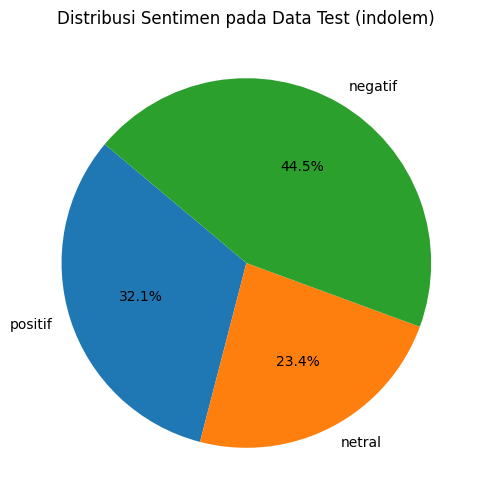

In [ ]:
# Fungsi untuk membuat pie chart
def plot_pie_chart(values, labels, title):
    plt.figure(figsize=(8, 6))
    plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.show()

# Menghitung jumlah masing-masing sentimen pada data_test
sentimen_counts_test = df_test_predictions['predicted_sentiment'].value_counts().sort_index()
plot_pie_chart(sentimen_counts_test, ['positif', 'netral', 'negatif'], "Distribusi Sentimen pada Data Test (indolem)")

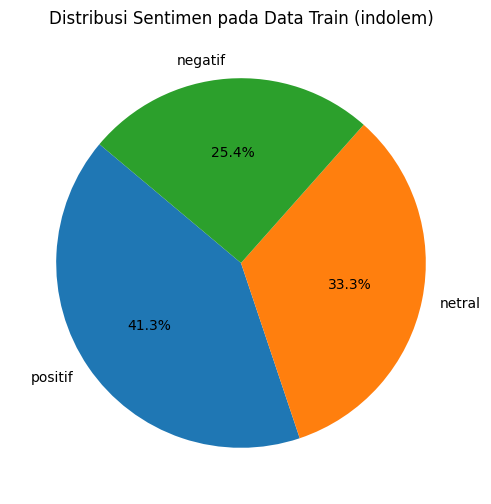

In [ ]:
# Fungsi untuk membuat pie chart
def plot_pie_chart(values, labels, title):
    plt.figure(figsize=(8, 6))
    plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.show()

# Menghitung jumlah masing-masing sentimen pada data_train
sentimen_counts_train = data_train['sentimen'].value_counts().sort_index()
plot_pie_chart(sentimen_counts_train, ['positif', 'netral', 'negatif'], "Distribusi Sentimen pada Data Train (indolem)")

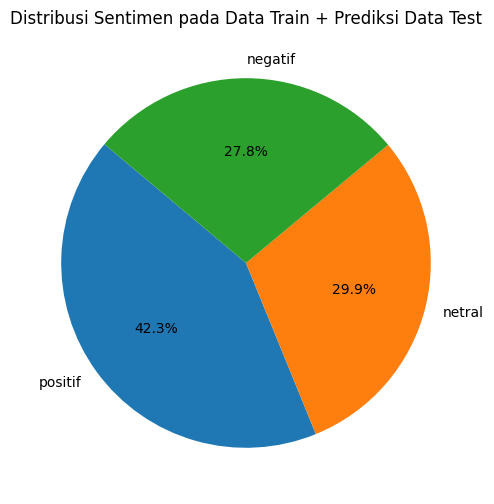

In [ ]:
# Menghitung jumlah masing-masing sentimen pada data_train + prediksi dari data_test
combined_sentiments = list(data_train['sentimen']) + list(test_pred_class)
combined_sentiments_counts = pd.Series(combined_sentiments).value_counts().sort_index()
plot_pie_chart(combined_sentiments_counts, ['positif', 'netral', 'negatif'], "Distribusi Sentimen pada Data Train + Prediksi Data Test")

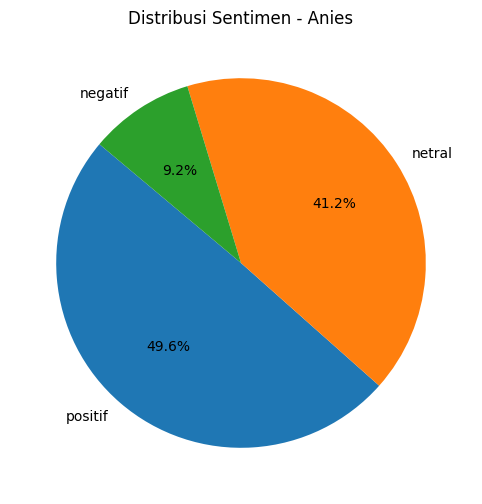

In [ ]:
# Visualisasi Distribusi Sentimen Berdasarkan Tokoh Politik
def plot_pie_for_politician(data, politician, title):
    sentiment_counts = data[data[politician] == 1]['sentimen'].value_counts().sort_index()
    plot_pie_chart(sentiment_counts, ['positif', 'netral', 'negatif'], title)

plot_pie_for_politician(data_train, 'anies', "Distribusi Sentimen - Anies")

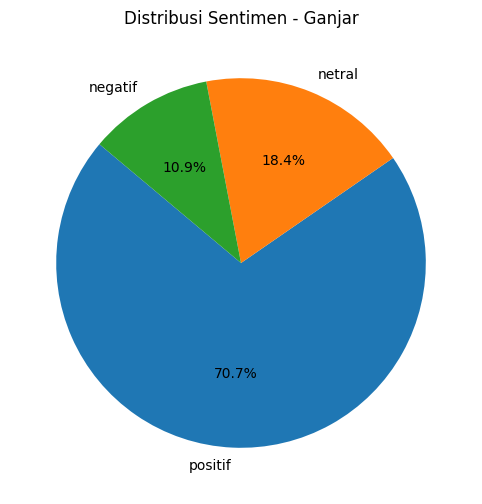

In [ ]:
plot_pie_for_politician(data_train, 'ganjar', "Distribusi Sentimen - Ganjar")

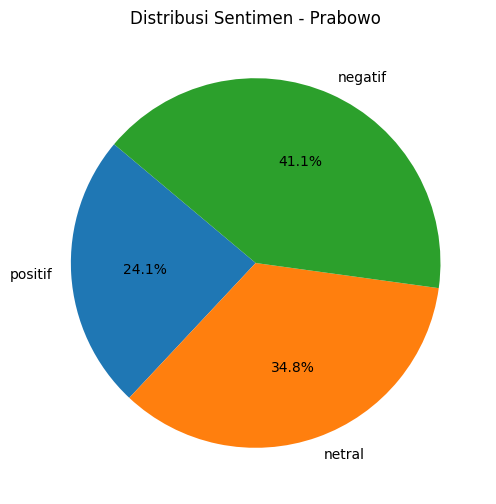

In [ ]:
plot_pie_for_politician(data_train, 'prabowo', "Distribusi Sentimen - Prabowo")

## 3.3 Indobert tweet

In [ ]:
# 2. Load IndoBERT model and tokenizer
model_name = 'indolem/indobertweet-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
config = BertConfig.from_pretrained(model_name, num_labels=3)
model = TFBertForSequenceClassification.from_pretrained(model_name, config=config, from_pt=True)

# Tokenize the input (X_train and X_val)
train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(X_val.tolist(), truncation=True, padding=True, max_length=128)

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), y_val))

# Custom loss function (if needed)
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# 3. Implement callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# 4. Train the model
optimizer = Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

# Verify data types and shapes
print("Training set types and shapes:")
for x, y in train_dataset.take(1):
    print("Input:", x['input_ids'].dtype, x['input_ids'].shape)
    print("Label:", y.dtype, y.shape)

print("\nValidation set types and shapes:")
for x, y in val_dataset.take(1):
    print("Input:", x['input_ids'].dtype, x['input_ids'].shape)
    print("Label:", y.dtype, y.shape)

# Training the model
history = model.fit(train_dataset.shuffle(1000).batch(32), epochs=20,
                    validation_data=val_dataset.batch(32), callbacks=[reduce_lr, early_stopping])

# Evaluate the model to check if the accuracy criteria is met
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]

print(f"Training Accuracy: {train_accuracy*100:.2f}%")
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/235k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training set types and shapes:
Input: <dtype: 'int32'> (128,)
Label: <dtype: 'int64'> ()

Validation set types and shapes:
Input: <dtype: 'int32'> (106,)
Label: <dtype: 'int64'> ()
Epoch 1/20
151/151 [==============================] - 191s 807ms/step - loss: 0.6232 - accuracy: 0.7281 - val_loss: 0.5172 - val_accuracy: 0.7766 - lr: 5.0000e-05
Epoch 2/20
151/151 [==============================] - 123s 812ms/step - loss: 0.3821 - accuracy: 0.8492 - val_loss: 0.5430 - val_accuracy: 0.7874 - lr: 5.0000e-05
Epoch 3/20
151/151 [==============================] - 127s 841ms/step - loss: 0.2247 - accuracy: 0.9206 - val_loss: 0.7026 - val_accuracy: 0.7749 - lr: 5.0000e-05
Epoch 4/20
151/151 [==============================] - 127s 843ms/step - loss: 0.1229 - accuracy: 0.9603 - val_loss: 0.8067 - val_accuracy: 0.7658 - lr: 5.0000e-05
Epoch 5/20
151/151 [==============================] - 127s 844ms/step - loss: 0.0760 - accuracy: 0.9755 - val_loss: 0.9419 - val_accuracy: 0.7666 - lr: 5.0000e-05
Epoc

In [ ]:
# 1. Classification Report
y_val_pred = model.predict(val_dataset.batch(32)).logits
y_val_pred_class = tf.argmax(y_val_pred, axis=1).numpy()
print(classification_report(y_val, y_val_pred_class, target_names=['positif', 'netral', 'negatif']))

38/38 [==============================] - 11s 217ms/step
              precision    recall  f1-score   support

     positif       0.84      0.89      0.86       487
      netral       0.72      0.67      0.69       412
     negatif       0.74      0.73      0.74       305

    accuracy                           0.77      1204
   macro avg       0.76      0.76      0.76      1204
weighted avg       0.77      0.77      0.77      1204



In [ ]:
# 2. Prediksi Sentimen pada data_test
data_test_preprocessed = data_test.map(prepro).apply(ganti_kata_alay)
test_encodings = tokenizer(data_test_preprocessed.tolist(), truncation=True, padding=True, max_length=128)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings)))
test_predictions = model.predict(test_dataset.batch(32)).logits
test_pred_class = tf.argmax(test_predictions, axis=1).numpy()

49/49 [==============================] - 15s 252ms/step


In [ ]:
# Mengubah data_test dan test_pred_class menjadi DataFrame
df_test_predictions = pd.DataFrame({
    'text': data_test_preprocessed,
    'predicted_sentiment': test_pred_class
})

# Mengganti nilai numerik pada 'predicted_sentiment' dengan label yang sesuai
sentiment_labels = {0: 'positif', 1: 'netral', 2: 'negatif'}
df_test_predictions['predicted_sentiment'] = df_test_predictions['predicted_sentiment'].map(sentiment_labels)

df_test_predictions

,text,predicted_sentiment
0,"komunitas jasa sablon kaos di kelurahan genuk,...",positif
1,zy zy its me enggak ada yang salah dalam penca...,negatif
2,ganjarpranowo hidup rakyat papua semoga dengan...,positif
3,99propaganda bengkeldodo ndons back bangsaygsu...,positif
4,teddgus ganjarpranowo teddy tau dan sangat sad...,netral
...,...,...
1557,abu waras jargon kampanye tim kampanye prabowo...,negatif
1558,ribuan perangkat desa dan kepala desa ditengar...,netral
1559,"ganjar presiden, mahfud md wakil, pilihan cerd...",positif
1560,"ganjar presiden, mahfud md wakil, impian jabar...",positif


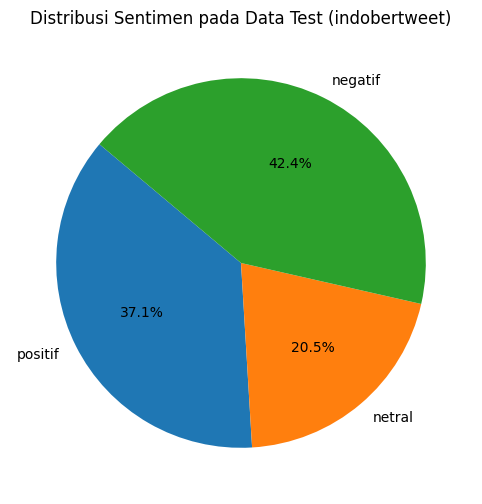

In [ ]:
# Fungsi untuk membuat pie chart
def plot_pie_chart(values, labels, title):
    plt.figure(figsize=(8, 6))
    plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.show()

# Menghitung jumlah masing-masing sentimen pada data_train
sentimen_counts_test = df_test_predictions['predicted_sentiment'].value_counts().sort_index()
plot_pie_chart(sentimen_counts_test, ['positif', 'netral', 'negatif'], "Distribusi Sentimen pada Data Test (indobertweet)")

Word Cloud

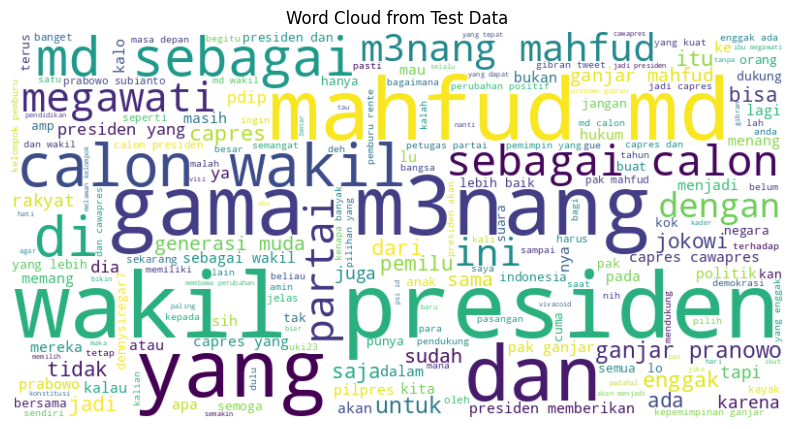

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_wordcloud(text, title):
    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, background_color='white').generate(text)

    # Plot the WordCloud image
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.title(title)
    plt.show()

# Example: Assuming you have a column named 'text' in your DataFrame
text_data = ' '.join(df_test_predictions['text'].values)
generate_wordcloud(text_data, "Word Cloud from Test Data")

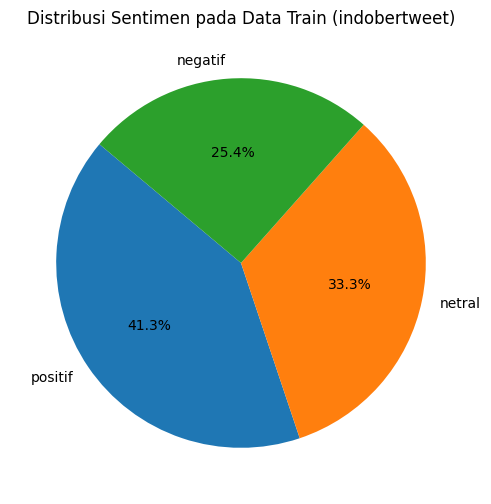

In [ ]:
# Fungsi untuk membuat pie chart
def plot_pie_chart(values, labels, title):
    plt.figure(figsize=(8, 6))
    plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.show()

# Menghitung jumlah masing-masing sentimen pada data_train
sentimen_counts_train = data_train['sentimen'].value_counts().sort_index()
plot_pie_chart(sentimen_counts_train, ['positif', 'netral', 'negatif'], "Distribusi Sentimen pada Data Train (indobertweet)")

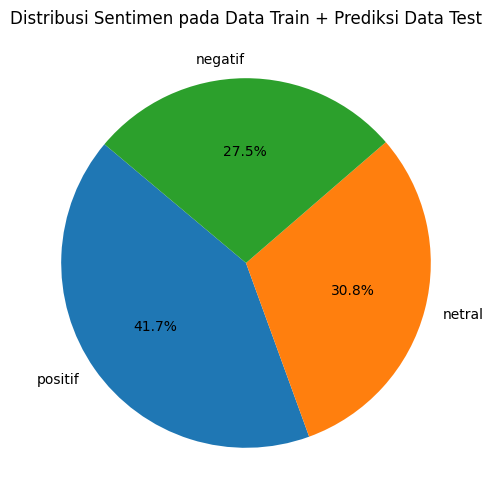

In [ ]:
# Menghitung jumlah masing-masing sentimen pada data_train + prediksi dari data_test
combined_sentiments = list(data_train['sentimen']) + list(test_pred_class)
combined_sentiments_counts = pd.Series(combined_sentiments).value_counts().sort_index()
plot_pie_chart(combined_sentiments_counts, ['positif', 'netral', 'negatif'], "Distribusi Sentimen pada Data Train + Prediksi Data Test")

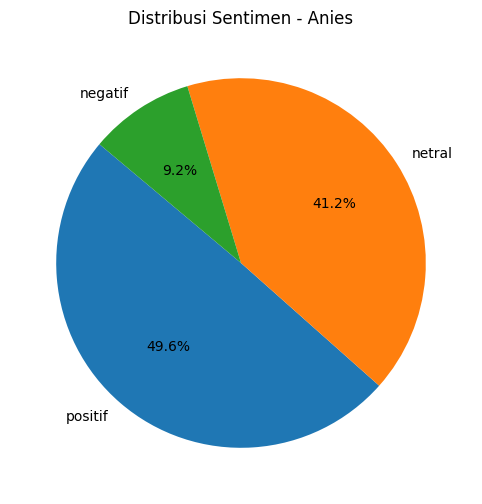

In [ ]:
# Visualisasi Distribusi Sentimen Berdasarkan Tokoh Politik
def plot_pie_for_politician(data, politician, title):
    sentiment_counts = data[data[politician] == 1]['sentimen'].value_counts().sort_index()
    plot_pie_chart(sentiment_counts, ['positif', 'netral', 'negatif'], title)

plot_pie_for_politician(data_train, 'anies', "Distribusi Sentimen - Anies")

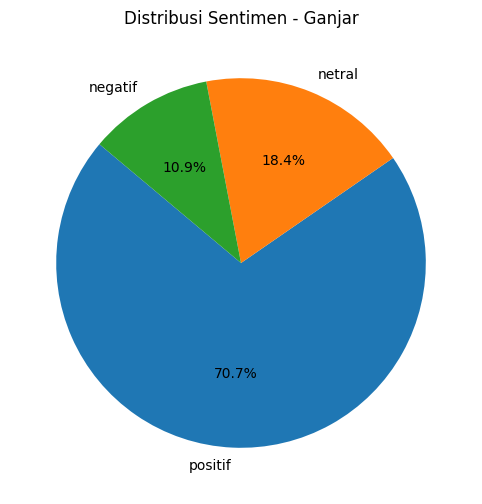

In [ ]:
plot_pie_for_politician(data_train, 'ganjar', "Distribusi Sentimen - Ganjar")

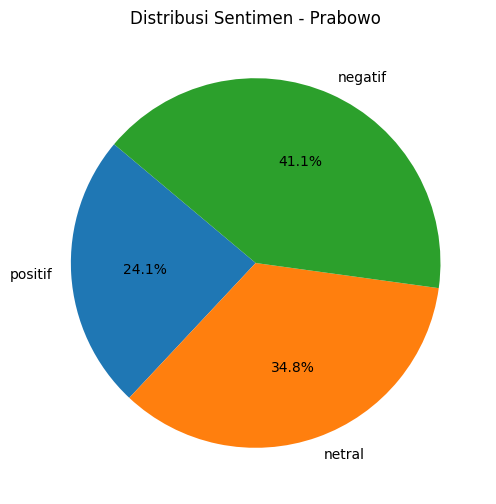

In [ ]:
plot_pie_for_politician(data_train, 'prabowo', "Distribusi Sentimen - Prabowo")

## 3.3 XLNet

In [ ]:
!pip install transformers
from transformers import XLNetTokenizer, TFXLNetForSequenceClassification, XLNetConfig

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
model_name = 'xlnet-base-cased'  # Replace with the appropriate XLNet model name if needed
tokenizer = XLNetTokenizer.from_pretrained(model_name)
config = XLNetConfig.from_pretrained(model_name, num_labels=3)  # Adjust num_labels if necessary
model = TFXLNetForSequenceClassification.from_pretrained(model_name, config=config)

# Tokenize the input (X_train and X_val)
train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True, max_length=64)
val_encodings = tokenizer(X_val.tolist(), truncation=True, padding=True, max_length=64)

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), y_val))

# Custom loss function (if needed)
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Implement callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# Train the model
optimizer = Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

# Verify data types and shapes (unchanged)
print("Training set types and shapes:")
for x, y in train_dataset.take(1):
    print("Input:", x['input_ids'].dtype, x['input_ids'].shape)
    print("Label:", y.dtype, y.shape)

print("\nValidation set types and shapes:")
for x, y in val_dataset.take(1):
    print("Input:", x['input_ids'].dtype, x['input_ids'].shape)
    print("Label:", y.dtype, y.shape)

# Training the model
history = model.fit(train_dataset.shuffle(1000).batch(32), epochs=5,
                    validation_data=val_dataset.batch(32), callbacks=[reduce_lr])

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/565M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetForSequenceClassification: ['lm_loss']
- This IS expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertF

Training set types and shapes:
Input: <dtype: 'int32'> (64,)
Label: <dtype: 'int64'> ()

Validation set types and shapes:
Input: <dtype: 'int32'> (64,)
Label: <dtype: 'int64'> ()
Epoch 1/5
151/151 [==============================] - 137s 561ms/step - loss: 1.0907 - accuracy: 0.4022 - val_loss: 1.0868 - val_accuracy: 0.4045 - lr: 5.0000e-05
Epoch 2/5
151/151 [==============================] - 81s 538ms/step - loss: 1.0547 - accuracy: 0.4217 - val_loss: 0.8709 - val_accuracy: 0.5831 - lr: 5.0000e-05
Epoch 3/5
151/151 [==============================] - 81s 534ms/step - loss: 0.8502 - accuracy: 0.5706 - val_loss: 0.7780 - val_accuracy: 0.6229 - lr: 5.0000e-05
Epoch 4/5
151/151 [==============================] - 80s 532ms/step - loss: 0.7366 - accuracy: 0.6512 - val_loss: 0.7380 - val_accuracy: 0.6645 - lr: 5.0000e-05
Epoch 5/5
151/151 [==============================] - 80s 532ms/step - loss: 0.6776 - accuracy: 0.7023 - val_loss: 0.6969 - val_accuracy: 0.7010 - lr: 5.0000e-05


In [ ]:
# Evaluate the model
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]

print(f"Training Accuracy: {train_accuracy*100:.2f}%")
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")

Training Accuracy: 81.53%
Validation Accuracy: 69.35%


In [ ]:
y_val_pred = model.predict(val_dataset.batch(32)).logits
y_val_pred_class = tf.argmax(y_val_pred, axis=1).numpy()
print(classification_report(y_val, y_val_pred_class, target_names=['positif', 'netral', 'negatif']))

38/38 [==============================] - 9s 160ms/step


NameError: name 'classification_report' is not defined

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_val_pred_class, target_names=['positif', 'netral', 'negatif']))

              precision    recall  f1-score   support

     positif       0.77      0.88      0.82       487
      netral       0.59      0.63      0.61       412
     negatif       0.73      0.49      0.58       305

    accuracy                           0.69      1204
   macro avg       0.69      0.66      0.67      1204
weighted avg       0.69      0.69      0.69      1204



In [ ]:
# 2. Prediksi Sentimen pada data_test
data_test_preprocessed = data_test.map(prepro).apply(ganti_kata_alay)
test_encodings = tokenizer(data_test_preprocessed.tolist(), truncation=True, padding=True, max_length=64)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings)))
test_predictions = model.predict(test_dataset.batch(32)).logits
test_pred_class = tf.argmax(test_predictions, axis=1).numpy()

49/49 [==============================] - 11s 162ms/step


In [ ]:
# Mengubah data_test dan test_pred_class menjadi DataFrame
df_test_predictions = pd.DataFrame({
    'text': data_test_preprocessed,
    'predicted_sentiment': test_pred_class
})

# Mengganti nilai numerik pada 'predicted_sentiment' dengan label yang sesuai
sentiment_labels = {0: 'positif', 1: 'netral', 2: 'negatif'}
df_test_predictions['predicted_sentiment'] = df_test_predictions['predicted_sentiment'].map(sentiment_labels)

df_test_predictions

,text,predicted_sentiment
0,"komunitas jasa sablon kaos di kelurahan genuk,...",positif
1,zy zy its me enggak ada yang salah dalam penca...,negatif
2,ganjarpranowo hidup rakyat papua semoga dengan...,positif
3,99propaganda bengkeldodo ndons back bangsaygsu...,netral
4,teddgus ganjarpranowo teddy tau dan sangat sad...,netral
...,...,...
1557,abu waras jargon kampanye tim kampanye prabowo...,positif
1558,ribuan perangkat desa dan kepala desa ditengar...,netral
1559,"ganjar presiden, mahfud md wakil, pilihan cerd...",positif
1560,"ganjar presiden, mahfud md wakil, impian jabar...",positif


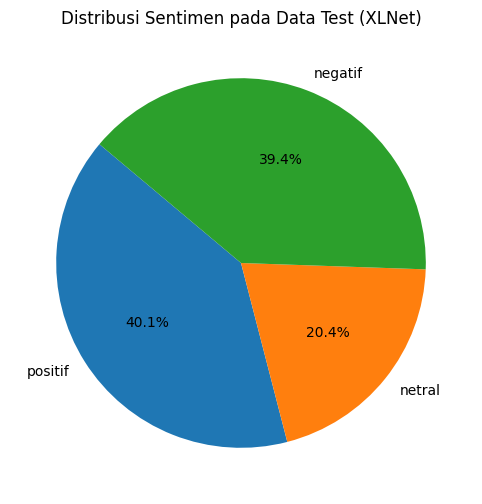

In [ ]:
#Fungsi untuk membuat pie chart
def plot_pie_chart(values, labels, title):
    plt.figure(figsize=(8, 6))
    plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.show()

# Menghitung jumlah masing-masing sentimen pada data_train
sentimen_counts_test = df_test_predictions['predicted_sentiment'].value_counts().sort_index()
plot_pie_chart(sentimen_counts_test, ['positif', 'netral', 'negatif'], "Distribusi Sentimen pada Data Test (XLNet)")

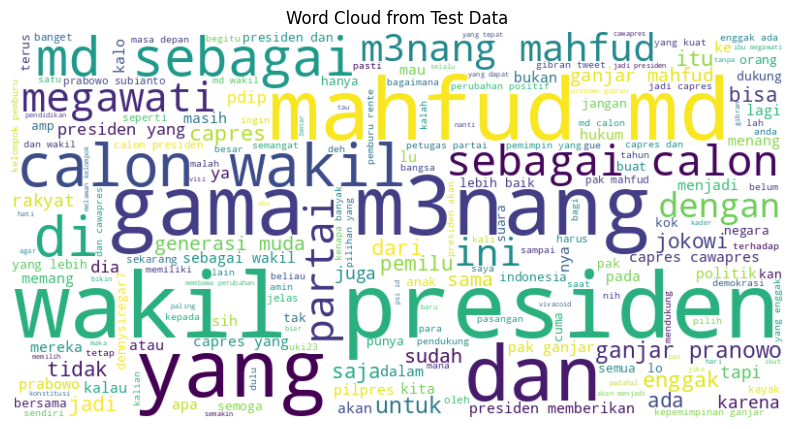

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_wordcloud(text, title):
    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, background_color='white').generate(text)

    # Plot the WordCloud image
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.title(title)
    plt.show()

# Example: Assuming you have a column named 'text' in your DataFrame
text_data = ' '.join(df_test_predictions['text'].values)
generate_wordcloud(text_data, "Word Cloud from Test Data")